# PHYS 3317 -- Band Structure

<font color="red"><em> Lee Swindell</em></font>

### Load Packages

In [1]:
from __future__ import division  #get rid of integer division bug
from scipy.sparse import *  # loads the functions to deal with sparse matrices
from showmat import showmat # loads display functions 
# if you get an error message, download showmat.py and put in directory with notebooks

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/lee/Desktop/python venvs/scipytest/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['kron', 'rand', 'identity', 'random', 'tril', 'hstack', 'bmat', 'extract', 'eye', 'vstack', 'triu']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [3]:
# This is our standard Hamiltonian Matrix that
# you call with the values of the function and the grid spacing dx
# Aside from that -- it is our standard 1D Hamiltonian matrix

def HamiltonianMatrix(potential,dx,periodic=True,hbar=1,mass=1):
    """HamiltonianMatrix(potential,dx,hbar=1,mass=1)
    generates a finite difference approximation to the hamiltonian operator H
    for the case of a single particle in a potential V(x)

    It is called by the following required arguments:
    potential -- a list of values for the potential
    dx -- the grid spacing
    
    It also has two optional arguments, which are assumed to be equal to unity if they
    are not specified
    hbar -- Planck's constant divided by 2 pi
    mass -- the particle mass
    """
    numpoints=len(potential)
    kin=-(0.5*hbar**2/mass)*SecondDerivMatrix(numpoints=numpoints,dx=dx,periodic=periodic) # calculate kinetic energy operator
    pot=PotentialMatrix(potential) #calculate potential energy operator
    return kin+pot

In [4]:
def PotentialMatrix(potential):
    """PotentialMatrix(potential)
    generates a finite difference approximation to the operator V(x).
    It is called by the following arguments:
    potential -- the list of the potential values
    """

    ln=len(potential)
    return dia_matrix((potential,0),shape=(ln,ln))
    

In [5]:
def SecondDerivMatrix(numpoints,dx,periodic) : 
    """SecondDerivMatrix(numpoints,dx,periodic) returns a sparse matrix
    which represents the second derivative -- using a 3-point derivative.  

    It takes periodic needed arguments:
    numpoints -- an integer which is how many points are in the grid
    dx -- the real space lattice spacing
    periodic -- do we use periodic boundary conditions?

    Setting periodic to "False" will give "hard wall boundaries"
    """
    unitlist=ones(numpoints)  # just a list of 1's whose length is equal to the length of the grid
    if periodic :
        return dia_matrix(       # we are generating a sparse matrix by specifying the diagonals
            ((unitlist/(dx**2),unitlist/(dx**2),-2*unitlist/(dx**2),unitlist/(dx**2),unitlist/(dx**2)),
            (1,-1,0,numpoints-1,1-numpoints)),  # this line specifies which the diagonals
            shape=(numpoints,numpoints))
    else :
        return dia_matrix(       # we are generating a sparse matrix by specifying the diagonals
            ((unitlist/(dx**2),unitlist/(dx**2),-2*unitlist/(dx**2)),
            (1,-1,0)),  # this line specifies which the diagonals
            shape=(numpoints,numpoints))

In [6]:
from scipy.sparse.linalg import eigsh  # load the function which calculates eigenvectors of hermitian matrices

### Binding and Antibinding orbitals

We are going to model the electronic properties of solids by looking at electron motion in the potentials from all of the nuclei.  

We will use a 1D model.  Given that we are in 1D, there is no reason to use a realistic potential.  Instead we should use one which is conceptually clean.  Here is one of my favorite 1D potentials -- it is just a smooth short range well  -- the square of a hyperbolic secant.

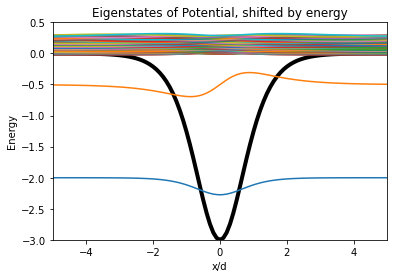

In [7]:
dx=0.1
maxx=200  # This is way bigger than it haves to be.  Try reducing it and see how the picture changes
xgrid=arange(-maxx,maxx,dx)
well =-3/cosh(xgrid)**2
ham=HamiltonianMatrix(potential=well,dx=dx,periodic=True)
energies,wavefunctions=eigsh(ham,k=100, sigma=-3.,  return_eigenvectors=True)
plot(xgrid,well,linewidth=4,color=(0,0,0)) #plot the  potential 
ylim(-3,0.5) # rescale the y-axis
xlim(-5,5)
xlabel("x/d") # label the x-axis
ylabel("Energy") # label the y-axis
title("Eigenstates of Potential, shifted by energy") # set title
#yticks(arange(-3,2,0.1)) # set the ticks on the y-axis to line up with the energies of the states
for index,en in enumerate(energies): # loop over the eigen-energies
    plot(xgrid,en-wavefunctions[:,index]) # plot each wavefunction, scaling and offsetting

As you can see by that figure, there are exactly two bound states in this potential -- and their energies are nice.  As the next line shows, the ground state has energy -2, and the first excited state has energy -0.5.

In [8]:
energies[:2]

array([-2.00095454, -0.50185365])

Here is a histogram of the energies.  Again we see two bound states and a continuum of scattering states.

Text(-1.2, 10, 'bound states')

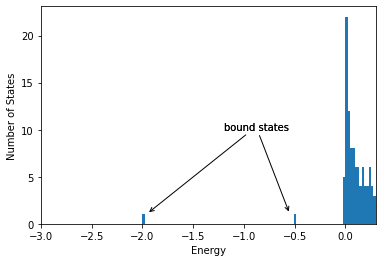

In [9]:
hist(energies,bins=100)
xlim(-3,0.3)
xlabel("Energy")
ylabel("Number of States")
annotate("bound states",(-1.95,1.1),(-1.2,10),arrowprops={"arrowstyle":"->"})
annotate("bound states",(-0.55,1.1),(-1.2,10),arrowprops={"arrowstyle":"->"})

Here is another way to show the data

Text(0, 0.5, 'Energy')

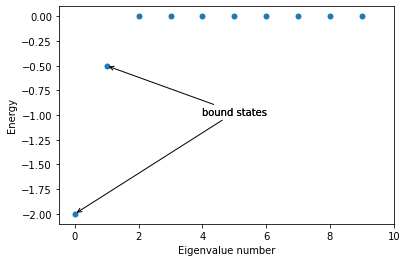

In [10]:
plot(energies[:10],".",ms=10)
xlim(-0.5,10)
annotate("bound states",(0,-2),(4,-1),arrowprops={"arrowstyle":"->"})
annotate("bound states",(1,-0.5),(4,-1),arrowprops={"arrowstyle":"->"})
xlabel("Eigenvalue number")
ylabel("Energy")

<b> Problem:</b> You will find that if you adjust the depth of the well, you can change the number of bound states.  What is roughly the depth at which we end up with only one bound state?  

In [11]:
Energy = -1

### Two wells

Lets now consider two of these wells.  First lets define a function which returns the hamiltonian matrix for more than one well

In [12]:
def multiwellham(locations,maxx,dx):
    grid=arange(-maxx,maxx,dx)
    pot=zeros(len(grid))
    for x in locations:
        pot=pot-3/cosh(grid-x)**2
    return HamiltonianMatrix(potential=pot,dx=dx,periodic=True)

We generate a Hamiltonian from it as follows -- the [-3,3] represents having a well at position 3 and position -3

In [13]:
ham2=multiwellham([-3,3],50,0.1)

We can plot the potential by just extracting it from the diagonals of this matrix

Text(0, 0.5, 'V')

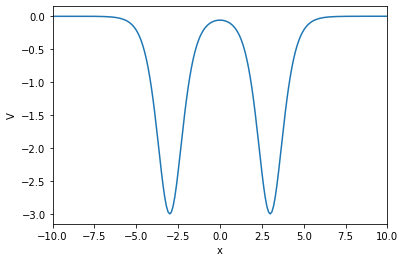

In [14]:
plot(arange(-50,50,0.1),ham2.diagonal()-100) # subtract off the diagonal component of the Laplacian to get the potential
xlim(-10,10)
xlabel("x")
ylabel("V")

We can find the energies as before

In [15]:
energies2,wavefunctions2=eigsh(ham2,k=10, sigma=-3.,  return_eigenvectors=True)

As you would expect, we have some near degeneracies

In [16]:
energies2

array([-2.00125021e+00, -2.00095342e+00, -5.17276255e-01, -4.87834194e-01,
       -3.44400576e-05,  2.16748853e-03,  2.23140229e-03,  8.86447886e-03,
        8.92182227e-03,  2.00128690e-02])

Text(0, 0.5, 'Energy')

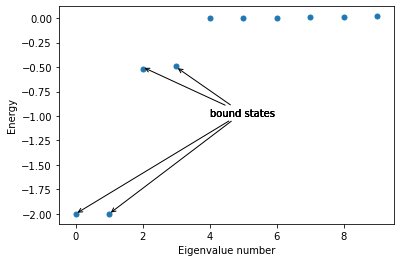

In [17]:
plot(energies2,".",ms=10)
xlim(-0.5,9.5)
annotate("bound states",(1,-2),(4,-1),arrowprops={"arrowstyle":"->"})
annotate("bound states",(0,-2),(4,-1),arrowprops={"arrowstyle":"->"})
annotate("bound states",(3,-0.5),(4,-1),arrowprops={"arrowstyle":"->"})
annotate("bound states",(2,-0.5),(4,-1),arrowprops={"arrowstyle":"->"})
xlabel("Eigenvalue number")
ylabel("Energy")

<b> Problem:</b> Make a plot of energy vs eigenvalue number for these same two wells, but separated by a distance of 2 instead of 6.

Text(0, 0.5, 'Energy')

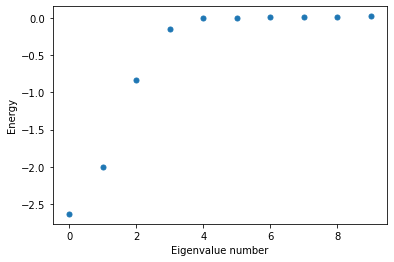

In [18]:
ham3=multiwellham([-1,1],50,0.1)
energies3,wavefunctions3=eigsh(ham3,k=10, sigma=-3.,  return_eigenvectors=True)
plot(energies3,".",ms=10)
xlim(-0.5,9.5)
xlabel("Eigenvalue number")
ylabel("Energy")

<b> Problem:</b> Make a plot of the lowest and first eigenvector when the separation is 2

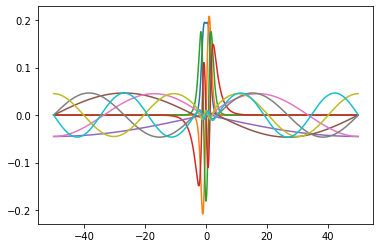

In [20]:
plot(arange(-50,50,0.1),wavefunctions3)
#wavefunctions[0]

To find out systematically how things work, we loop through the values of the separation.  

In [21]:
dvals=arange(1,5,0.1)     # This is a list of the values of d we will use
elist=[]                  # Here is a blank list we will put the eigenvalues in
wlist=[]                  # Here is a blank list we will put the eigenvectors in
for d in dvals:                                               # loop over d
    h=multiwellham([-d/2.,d/2.],50,0.1)                       # generate the matrix
    e,w=eigsh(h,k=50, sigma=-4.,  return_eigenvectors=True)   # find the eigenvalues and eigenvectors
    elist.append(e)       # add the eigenvalues to elist
    wlist.append(w)       # add the eigenvectors to wlist

The following code plots the energies as a function of distance

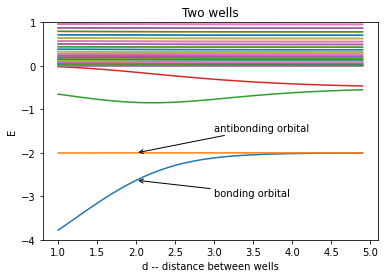

In [22]:
earray=array(elist).transpose()
for el in earray:
    plot(dvals,el)
ylim(-4,1)
annotate("bonding orbital",(dvals[10],earray[0,10]),(3,-3),arrowprops={"arrowstyle":"->"})
annotate("antibonding orbital",(dvals[10],earray[1,10]),(3,-1.5),arrowprops={"arrowstyle":"->"})
xlabel("d -- distance between wells")
ylabel("E")
title("Two wells")
savefig("doublewellen.png")

The following cell plots the wavefunctions for various separations.  Note how when the wells get too close, they just form one big well

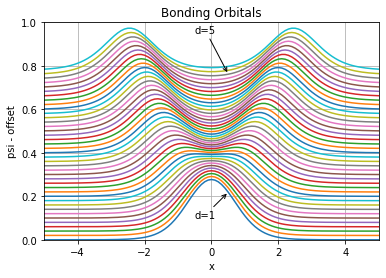

In [23]:

warray=array(wlist)
xvals=arange(-50,50,0.1)
for index,d in enumerate(dvals): 
    plot(xvals,sign(warray[index,500,0])*warray[index,:,0]+0.02*index);
xlim(-5,5)
ylim(0,1)
title("Bonding Orbitals")
annotate("d=1",(xvals[505],warray[0,505,0]),(-0.5,0.1),arrowprops={"arrowstyle":"->"})
annotate("d=5",(xvals[505],warray[-1,505,0]+0.02*index),(-0.5,0.95),arrowprops={"arrowstyle":"->"})
grid()
xlabel("x")
ylabel("psi - offset");

Here is the same thing for the first excited State

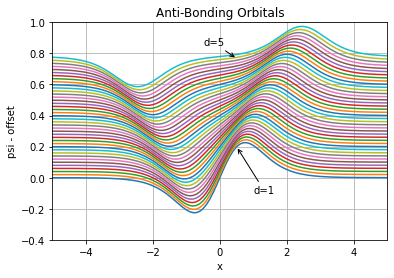

In [24]:
warray=array(wlist)
xvals=arange(-50,50,0.1)
for index,d in enumerate(dvals): 
    plot(xvals,sign(warray[index,510,1])*warray[index,:,1]+0.02*index);
xlim(-5,5)
ylim(-0.4,1)
title("Anti-Bonding Orbitals")
annotate("d=1",(xvals[505],-warray[0,505,1]),(1,-0.1),arrowprops={"arrowstyle":"->"})
annotate("d=5",(xvals[505],-warray[-1,505,1]+0.02*index),(-0.5,0.85),arrowprops={"arrowstyle":"->"})
grid()
xlabel("x")
ylabel("psi - offset");

### Multiple Wells

Here is a many-well limit (41 wells) of this sort of reasoning.  [Warning -- it is not particularly fast to run.]

In [25]:
dvals=arange(1,5,0.1)
bigelist=[]
bigwlist=[]
for d in dvals:
    h=multiwellham(d*arange(-20,21,1),110,0.1)
    e,w=eigsh(h,k=100, sigma=-6.,  return_eigenvectors=True)
    bigelist.append(e)
    bigwlist.append(w)

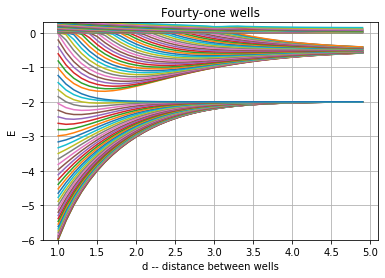

In [26]:
earray=array(bigelist).transpose()
for el in earray:
    plot(dvals,el)
grid()
xlabel("d -- distance between wells")
ylabel("E")
title("Fourty-one wells")
ylim(-6,0.3)
savefig("fourtyonewellsen.png")

As you can see, there are "bands" of energy where there are states, and "gaps" where there are no states.  A metal has the fermi energy is inside a band, while an insulator has it in a gap.

Here are what some of the wavefunctions look like -- say at distance 3

In [27]:
dvals[20]

3.0000000000000018

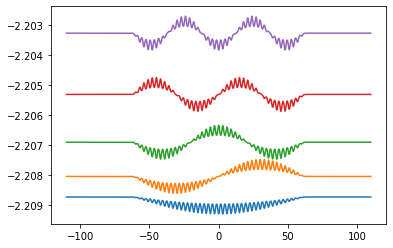

In [28]:
xvals=arange(-110,110,0.1)
laste=bigelist[20]
lastw=bigwlist[20]
for n in range(5):
    plot(xvals,0.01*lastw[:,n]+laste[n])

Another interesting plot is a histogram of the energies -- the bands and gaps should be aparent.

Text(0, 0.5, 'Number of states')

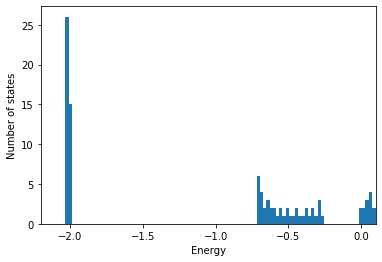

In [29]:
hist(bigelist[30],bins=100);
xlim(-2.2,0.1)
xlabel("Energy")
ylabel("Number of states")

This next one is just eye candy.  I plotted the lowest energy wavefunction of the 40 wells as a function of the separation.

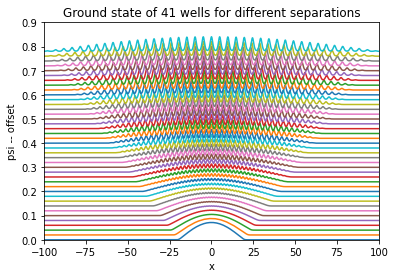

In [30]:
warray=array(bigwlist)
xvals=arange(-110,110,0.1)
for index,d in enumerate(dvals): 
    plot(xvals,sign(warray[index,1020,0])*warray[index,:,0]+0.02*index);
xlim(-100,100)
ylim(0,0.9)
xlabel("x")
ylabel("psi -- offset")
title("Ground state of 41 wells for different separations");

In [32]:
warray=array(bigwlist)
xvals=arange(-110,110,0.1)
for index,d in enumerate(dvals): 
    plot(xvals,sign(warray[index,1020+10*d,1])*warray[index,:,1]+0.02*index);
xlim(-100,100)
ylim(-0.2,0.9)
xlabel("x")
ylabel("psi -- offset")
title("First excited state of 41 wells for different separations");

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

# Wannier States

As you recall, in the two-well case, we could take linear combinations of the eigenstates to get the "left" and "right" states.  The analogous procedure here will sum up states in the lowest band to get localized "Wannier" states

First lets generate the lowest band with 41 wells

In [33]:
h2=multiwellham(5*arange(-20,21,1),110,0.1)
e2,w2=eigsh(h2,k=41, sigma=-2.,  return_eigenvectors=True)

In [34]:
xgrid = arange(-110,110,0.1)

These wavefunctions are kind of complex

Text(0.5, 1.0, 'eigenstates in lowest band')

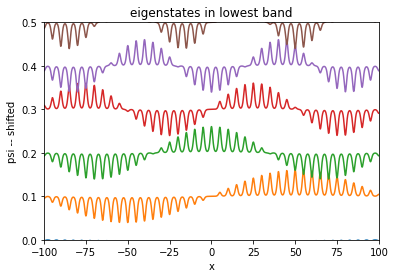

In [35]:
for num,state in enumerate(w2.transpose()):
    plot(xgrid,state+0.1*num)
ylim(0,0.5)
xlim(-100,100)
xlabel("x")
ylabel("psi -- shifted")
title("eigenstates in lowest band")

Since they can be thought of as a bunch of spikes, we can more simply represent them by just 
evaluating the wavefunctions at each well.  We will need the position of each of the wells

In [36]:
xgrid=arange(-110,110,0.1)
wellpos=50*arange(-20,21,1)+1100
wellposx=5*arange(-20,21,1)
wellpos # this is the index of xgrid corresponding to the location of each well

array([ 100,  150,  200,  250,  300,  350,  400,  450,  500,  550,  600,
        650,  700,  750,  800,  850,  900,  950, 1000, 1050, 1100, 1150,
       1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700,
       1750, 1800, 1850, 1900, 1950, 2000, 2050, 2100])

Text(0.5, 1.0, 'envelope of eigenstates in lowest band')

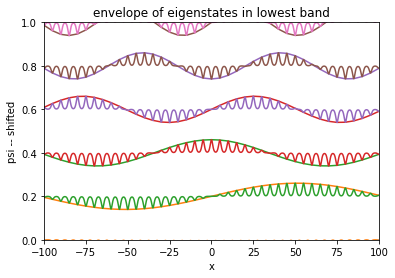

In [37]:
for num,state in enumerate(w2[wellpos].transpose()):
    plot(wellposx,state+0.2*num)
for num,state in enumerate(w2.transpose()):
    plot(xgrid,state+0.2*num)
xlim(-100,100)
ylim(0,1)
xlabel("x")
ylabel("psi -- shifted")
title("envelope of eigenstates in lowest band")

I am now going to take linear superpositions of the 41 wavefunctions, to try to make localized states.  The trick I will use is to project the position operator into the lowest band

In [38]:
projx=(w2.transpose()*xgrid).dot(w2)

In [39]:
from scipy.linalg import eigh

In [40]:
pos,coefs=eigh(projx)

In [41]:
localstates=(coefs.transpose()).dot(w2.transpose())

(0.0, 0.5)

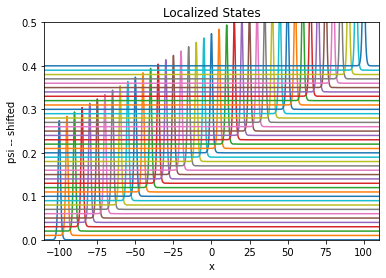

In [42]:
for num,state in enumerate(localstates):
    plot(xgrid,abs(state)+0.01*num)
title("Localized States")
xlabel("x")
ylabel("psi -- shifted")
xlim(-110,110)
ylim(0,0.5)

By the orthogonality of the eigenstates of a Hermitian operator, these localized states are orthogonal

In [43]:
overlaps=localstates.dot(localstates.transpose())

We can look at these overlaps

In [44]:
overlaps

array([[ 1.00000000e+00, -9.51575987e-16,  2.69788891e-15, ...,
        -8.77982730e-17, -3.43217599e-16, -2.40693137e-16],
       [-9.51575987e-16,  1.00000000e+00,  2.04612249e-15, ...,
         1.18237419e-16, -1.91418120e-16, -2.73830452e-16],
       [ 2.69788891e-15,  2.04612249e-15,  1.00000000e+00, ...,
        -4.81392620e-16,  2.16699820e-17, -6.21568889e-17],
       ...,
       [-8.77982730e-17,  1.18237419e-16, -4.81392620e-16, ...,
         1.00000000e+00,  7.67858256e-16, -3.06561151e-16],
       [-3.43217599e-16, -1.91418120e-16,  2.16699820e-17, ...,
         7.67858256e-16,  1.00000000e+00, -7.48339209e-16],
       [-2.40693137e-16, -2.73830452e-16, -6.21568889e-17, ...,
        -3.06561151e-16, -7.48339209e-16,  1.00000000e+00]])

If that looked good (more-or-less like an identity matrix), you can print it prettier with the following.  I have been warned that if things are ugly, the showmat command may cause your computer to hang.

In [45]:
showmat(overlaps)

1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


Interestingly, in order for the overlaps between neighboring states to vanish, the wavefunctions must go negative at some place

(-0.001, 0.005)

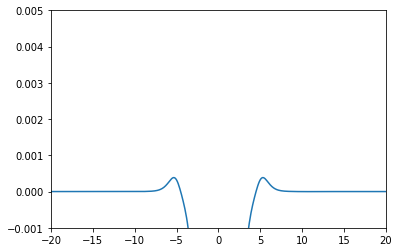

In [46]:
plot(xgrid,-localstates[20])
xlim(-20,20)
ylim(-0.001,0.005)

(-110.0, -80.0)

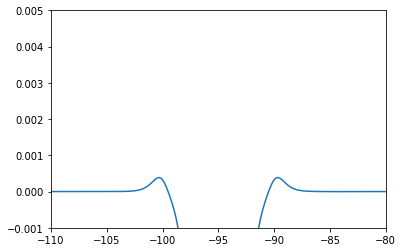

In [47]:
plot(xgrid,localstates[1])
ylim(-0.001,0.005)
xlim(-110,-80)

Finally, we can project the Hamiltonian into this space

In [48]:
hproj=localstates.dot(h2.dot(localstates.transpose()))

Interestingly, the projected Hamiltonian has exactly the form of our finite difference approximation (up to an uninteresting over-all shift)!!!

In [49]:
showmat(hproj)

-2,$0.1\cdot10^{-2}$,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
$0.1\cdot10^{-2}$,-2,$-0.1\cdot10^{-2}$,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,$-0.1\cdot10^{-2}$,-2,$-0.1\cdot10^{-2}$,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,$-0.1\cdot10^{-2}$,-2,$-0.1\cdot10^{-2}$,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,$-0.1\cdot10^{-2}$,-2,$-0.1\cdot10^{-2}$,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,$-0.1\cdot10^{-2}$,-2,$-0.1\cdot10^{-2}$,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,$-0.1\cdot10^{-2}$,-2,$-0.1\cdot10^{-2}$,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,$-0.1\cdot10^{-2}$,-2,$-0.1\cdot10^{-2}$,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,$-0.1\cdot10^{-2}$,-2,$-0.1\cdot10^{-2}$,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,$-0.1\cdot10^{-2}$,-2,$0.1\cdot10^{-2}$,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,,,,,,,,,$0.1\cdot10^{-2}$,-2,$0.1\cdot10^{-2}$,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
